In [7]:
from LevelMethod import LevelMethod
import pandas as pd
import numpy as np
import logging
import time
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

import sys
sys.path.insert(1, '../')

from config import shuffled_csv, path_exps
from NN import NN_model, Sigmoid, MSE, L1_reg

from NN.utility import batch_train, batch_out, Model_Wrapper
from LBFGS import LBFGS
from testing import multi_run

data = pd.read_csv(shuffled_csv, index_col=0).to_numpy()
data = data[:100, :]
n_samples = data.shape[0]
X_data = data[:, :10]
Y_data = data[:, 10:]

Y_scaler = StandardScaler()
Y_scaled = Y_scaler.fit_transform(Y_data)

# np.random.seed(11)
model = NN_model([10, 20, 20, 2], Sigmoid, MSE)
model.init_weights()
reg_loss = L1_reg(1e-4)

# logging.basicConfig(level="INFO")
f = Model_Wrapper(model, X_data, Y_scaled, reg_loss)
x = model.Weights
max_feval = 5000

In [8]:
import seaborn as sns

def geo_mean(iterable):
    a = np.array(iterable)
    return a.prod() ** (1.0 / len(a))

def pair_vector(vector_list):
    maxlen = len(max(vector_list, key=len))
    for i in range(len(vector_list)):
        lastEl = len(vector_list[i]) - 1
        tmpArray = np.full((maxlen - lastEl - 1, 1), vector_list[i][lastEl])
        vector_list[i] = np.array(np.concatenate((vector_list[i], tmpArray), axis=None))
    return vector_list

runs = 3

bundle_f_values = []
bundle_runtimes = []
bundle_f_evals = []
bundle_f_times = []

lbfgs_f_values = []
lbfgs_runtimes = []
lbfgs_f_evals = []
lbfgs_f_times = []

for i in range(runs):
    solver = LevelMethod(lambda_=0.7, bounds=1, max_iter=max_feval, verbose=False)
    model.init_weights()
    x = model.Weights

    start_time = time.process_time()
    status = solver.solve(f, x)
    end_time = time.process_time()
    runtime = end_time-start_time
    bundle_runtimes.append(runtime)
    bundle_f_times.append(solver.times["step"])
    #bundle_f_evals.append(solver.feval)
    bundle_f_values.append(solver.f_values)

for i in range(runs):
    solver = LBFGS(eps=1e-4,max_feval=max_feval,M=500,m1=0.01,m2=0.7)
    model.init_weights()
    x = model.Weights

    start_time = time.process_time()
    status = solver.solve(f, x)
    end_time = time.process_time()
    runtime = end_time-start_time

    lbfgs_runtimes.append(runtime)
    lbfgs_f_values.append(solver.f_values)
    lbfgs_f_times.append(solver.time_evaluations)
    lbfgs_f_evals.append(solver.feval)

bundle_f_times = [list(np.cumsum(step_times)) for step_times in bundle_f_times]

print("Solver \t\tMean runtime\t\tstd runtime")
print(f"Level Bundle\t\t{np.mean(bundle_runtimes)}\t{np.std(bundle_runtimes)}")
print(f"LBFGS\t\t{np.mean(lbfgs_runtimes)}\t{np.std(lbfgs_runtimes)}")

Solver 		Mean runtime		std runtime
Level Bundle		156.67110333333335	7.385889975457773
LBFGS		12.211056666666687	1.4324463402811565


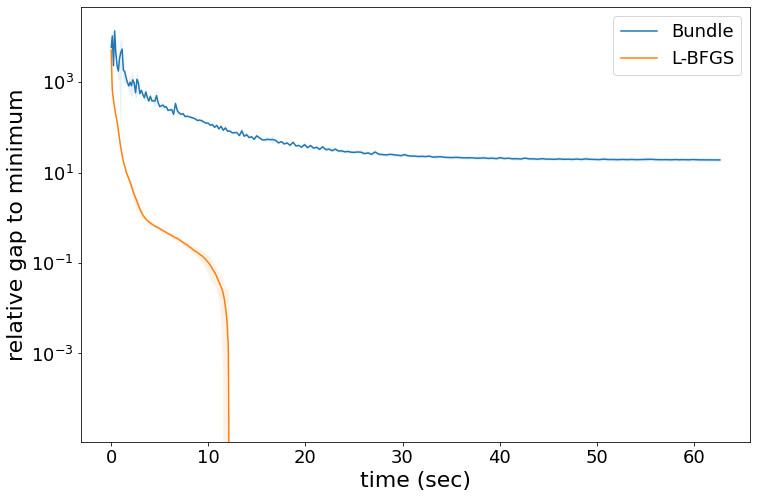

In [13]:
if lbfgs_f_values is not None and bundle_f_values is not None: 
    run_1 = pair_vector(bundle_f_values)
    run_2 = pair_vector(lbfgs_f_values)
    df_1 = pd.DataFrame(run_1).melt()
    df_1['function'] = ["bundle"] * len(df_1.index)
    df_2 = pd.DataFrame(run_2).melt()
    df_2['function'] = ["lbfgs"] * len(df_2.index)
    time_1 = pair_vector(bundle_f_times)
    time_2 = pair_vector(lbfgs_f_times)
    df_3 = pd.DataFrame(time_1).melt()
    df_3['function'] = ["bundle"] * len(df_3.index)
    df_4 = pd.DataFrame(time_2).melt()
    df_4['function'] = ["lbfgs"] * len(df_4.index)
    X1 = []
    Y1 = []
    y1_std = []
    X2 = []
    Y2 = []
    y2_std = []

    for i in range(0,len(df_1["value"].to_numpy()),runs):
        X1.append(np.mean(df_3["value"].to_numpy()[i:i+runs]))
        Y1.append(np.mean(df_1["value"].to_numpy()[i:i+runs]))
        y1_std.append(np.std(df_1["value"].to_numpy()[i:i+runs]))

    for i in range(0,len(df_2["value"].to_numpy()),runs):
        X2.append(np.mean(df_4["value"].to_numpy()[i:i+runs]))
        Y2.append(np.mean(df_2["value"].to_numpy()[i:i+runs]))
        y2_std.append(np.std(df_2["value"].to_numpy()[i:i+runs]))

    f_star = min(min(Y1),min(Y2))
    for i in range(len(Y1)):
        Y1[i] = (Y1[i] - f_star) / f_star
        y1_std[i] = y1_std[i]/f_star
    for i in range(len(Y2)):
        Y2[i] = (Y2[i] - f_star) / f_star
        y2_std[i] = y2_std[i]/f_star
    
    # Plot fevals
    fig, ax = plt.subplots(figsize=(12,8))
    plt.rcParams.update({'font.size': 18,'font.weight':'normal','font.family':'sans-serif'})
    ax.plot(np.asarray(X1)-X1[0],Y1, label='Bundle')
    ax.fill_between(np.asarray(X1)-X1[0], np.asarray(Y1)-np.asarray(y1_std),np.asarray(Y1)+np.asarray(y1_std),alpha=0.1,interpolate = True)
    ax.plot(np.asarray(X2)-X2[0],Y2, label='L-BFGS')
    ax.fill_between(np.asarray(X2)-X2[0], np.asarray(Y2)-np.asarray(y2_std),np.asarray(Y2)+np.asarray(y2_std),alpha=0.1,interpolate = True)
    plt.yscale("log")
    plt.legend()
    ax.set_xlabel('time (sec)',fontsize=22)
    ax.set_ylabel('relative gap to minimum',fontsize=22)
    plt.show()

In [12]:
ratios = np.zeros_like(Y2)
for i in range(len(Y2)-2):
    ratios[i+1] = Y2[i]/Y2[i+1]
print(ratios) 

[0.         1.62188443 1.60886686 1.30057074 1.28367003 1.21652806
 1.16112629 1.12170665 1.16069004 1.04738155 1.04744749 1.06227839
 1.04961174 1.05014933 1.05371315 1.02559484 1.03704964 1.04450299
 1.06697959 1.06662327 1.03996015 1.03660284 1.02483616 1.0459917
 1.02759874 1.04287427 1.04284743 1.03695173 1.02489662 1.03898575
 1.05490581 1.05574481 1.03989473 1.02028748 1.01411744 1.02337138
 1.04392358 1.03782712 1.02179004 1.01630628 1.02359578 1.03925465
 1.02649044 1.03187665 1.02863715 1.02652333 1.03294001 1.03172526
 1.02454252 1.03393137 1.03562821 1.03494005 1.03954022 1.02569942
 1.029401   1.04390305 1.03818271 1.03523379 1.04088575 1.04875789
 1.0794131  1.05251475 1.03984025 1.02698364 1.03426997 1.04900278
 1.0502032  1.03872627 1.04881731 1.04445484 1.04576991 1.04497225
 1.04367787 1.04130901 1.04076842 1.05540119 1.05745654 1.04020677
 1.02752582 1.03126442 1.04396908 1.04457749 1.03605465 1.04656614
 1.03246825 1.03535536 1.04010374 1.0318926  1.0258173  1.03192